In [1]:
import sys
sys.path.append('..')

import dgl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn
from sklearn.metrics import roc_auc_score
from util import Group
import pickle

Using backend: pytorch


In [2]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue

        edges = graph.edges(etype=etype)

        ground_truth[edges[0], edges[1]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return ground_truth, repos_per_user.numpy()

In [3]:
def process_edge_data(graph, edge_data):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ratings = np.zeros((number_of_users, number_of_repos))
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        edges = graph.edges(etype=etype)
        data = torch.squeeze(edge_data[etype]).numpy()
        ratings[edges[0], edges[1]] = np.maximum(ratings[edges[0], edges[1]], data)
    
    return ratings

In [4]:
def compute_auc(graph, pos_score, neg_score):
    auc_scores = []
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        pos_data = torch.squeeze(pos_score[etype])
        neg_data = torch.squeeze(neg_score[etype])
        
        scores = torch.cat([pos_data, neg_data]).numpy()
        labels = torch.cat(
            [torch.ones(pos_data.shape[0]), torch.zeros(neg_data.shape[0])]).numpy()

        auc_score = roc_auc_score(labels, scores)

        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [5]:
interaction_matrix = pickle.load(open('../data/interaction_matrix.p', 'rb'))
user_repos = np.sum(interaction_matrix, axis=1)
user_1_repo = np.where(user_repos==1)[0]

In [6]:
training_results = []

g, l = dgl.load_graphs('../data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]
train_pos_g = g[3]
train_neg_g = g[4]
valid_pos_g = g[5]
valid_neg_g = g[6]
test_pos_g = g[7]
test_neg_g = g[8]

user_feat = train_graph.ndata['graph_data']['user']
repo_feat = train_graph.ndata['graph_data']['repo']

EPOCH = 100
TOP_K = 10
REPO_INPUT_SIZE = repo_feat.shape[1]
USER_INPUT_SIZE = user_feat.shape[1]
USER_REPO_OUTPUT_SIZE = 125
HIDDEN_OUTPUT_SIZE = 96
OUT_SIZE = 50

model = Model(train_graph, USER_INPUT_SIZE, REPO_INPUT_SIZE, USER_REPO_OUTPUT_SIZE, HIDDEN_OUTPUT_SIZE, OUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

training_loops = 0
total_loss = 0
total_valid_loss = 0
valid_loss = 0

for epoch in range(EPOCH):
    model.train()
    pos_score, neg_score = model(train_graph, train_pos_g, train_neg_g, user_feat, repo_feat)
    loss = loss_fn(pos_score, neg_score)

    total_loss += loss.item()
    training_loops += 1

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_avg_loss = total_loss / training_loops

    model.eval()
    with torch.no_grad():
        valid_user_feat = valid_graph.ndata['graph_data']['user']
        valid_repo_feat = valid_graph.ndata['graph_data']['repo']
        pos_score, neg_score = model(valid_graph, valid_pos_g, valid_neg_g, valid_user_feat, valid_repo_feat)
        valid_loss = loss_fn(pos_score, neg_score)
        total_valid_loss += valid_loss.item()
        valid_avg_loss = total_valid_loss / training_loops

    if epoch % 5 == 0:
        # valid top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            valid_mean_hit_rate = 0
            valid_group_hit_rate = {}
            hit_rates = np.zeros(valid_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            valid_mrr = 0
            valid_group_mrr = {}
            mrr = np.zeros(valid_graph.num_nodes('user'))
            mrr_groups = Group()

            # nDCG
            valid_ndcg = 0
            valid_group_ndcg = {}
            ndcg = np.zeros(valid_graph.num_nodes('user'))
            ndcg_groups = Group()
        
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(valid_graph, out)
            user_repo_rating = process_edge_data(valid_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_valid_data[i].argsort(descending=True)
                filter_index = ground_truth_valid_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                elif number_of_ground_truth == 0:
                    mrr[i] == -1
                
                # nDCG
                if number_of_ground_truth == 0:
                    ndcg[i] = -1
                else:
                    relevance_score = ground_truth_valid_data[i].numpy()[recommendation][:min(number_of_ground_truth, TOP_K)]
                    relevance_score_idea = ground_truth_valid_data[i][ground_truth].numpy()[:min(number_of_ground_truth, TOP_K)]
                    pow_rel = np.power(2, relevance_score) - 1
                    pow_rel_idea = np.power(2, relevance_score_idea) - 1
                    ranks = np.arange(start=1, stop=len(relevance_score) + 1)
                    log_rank = np.log2(ranks + 1)
                    dcg = np.sum(pow_rel / log_rank)
                    idcg = np.sum(pow_rel_idea / log_rank)
                    ndcg[i] = dcg / idcg

                # grouping
                if repos_per_user_valid[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                    ndcg_groups['0-5'].append(i)
                    if repos_per_user_valid[i] == 1 and i in user_1_repo:
                        hit_rate_groups['1'].append(i)
                        mrr_groups['1'].append(i)
                        ndcg_groups['1'].append(i)
                elif repos_per_user_valid[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                    ndcg_groups['5-10'].append(i)
                elif repos_per_user_valid[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                    ndcg_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)
                    ndcg_groups['15-over'].append(i)

            # hit rate mean
            valid_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                valid_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            valid_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                valid_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])
            
            # nDCG mean
            valid_ndcg = np.mean(ndcg[ndcg>-1])
            for group_name, group_indices in ndcg_groups.items():
                valid_group_ndcg[group_name] = np.mean(ndcg[group_indices][ndcg[group_indices]>-1])
        
        # test top k recommendation
        model.eval()
        with torch.no_grad():
            # hit rate
            test_mean_hit_rate = 0
            test_group_hit_rate = {}
            hit_rates = np.zeros(test_graph.num_nodes('user'))
            hit_rate_groups = Group()

            # MRR
            test_mrr = 0
            test_group_mrr = {}
            mrr = np.zeros(test_graph.num_nodes('user'))
            mrr_groups = Group()

            # nDCG
            test_ndcg = 0
            test_group_ndcg = {}
            ndcg = np.zeros(test_graph.num_nodes('user'))
            ndcg_groups = Group()
        
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(test_graph, out)
            user_repo_rating = process_edge_data(test_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.argsort()[::-1][:TOP_K]
                index_sorted = ground_truth_test_data[i].argsort(descending=True)
                filter_index = ground_truth_test_data[i][index_sorted] > 0
                ground_truth = index_sorted[filter_index]

                intersections, recommendation_index, ground_truth_index = np.intersect1d(recommendation, ground_truth, return_indices=True)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth)

                # hit rate
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = hit_rate

                # MRR
                if number_of_intersections > 0:
                    if recommendation_index[0] <= TOP_K:
                        mrr[i] = 1 / (recommendation_index[0] + 1)
                elif number_of_ground_truth == 0:
                    mrr[i] == -1

                # nDCG
                if number_of_ground_truth == 0:
                    ndcg[i] = -1
                else:
                    relevance_score = ground_truth_test_data[i].numpy()[recommendation][:min(number_of_ground_truth, TOP_K)]
                    relevance_score_idea = ground_truth_test_data[i][ground_truth].numpy()[:min(number_of_ground_truth, TOP_K)]
                    pow_rel = np.power(2, relevance_score) - 1
                    pow_rel_idea = np.power(2, relevance_score_idea) - 1
                    ranks = np.arange(start=1, stop=len(relevance_score) + 1)
                    log_rank = np.log2(ranks + 1)
                    dcg = np.sum(pow_rel / log_rank)
                    idcg = np.sum(pow_rel_idea / log_rank)
                    ndcg[i] = dcg / idcg

                # grouping
                if repos_per_user_test[i] < 5:
                    hit_rate_groups['0-5'].append(i)
                    mrr_groups['0-5'].append(i)
                    ndcg_groups['0-5'].append(i)
                    if repos_per_user_test[i] == 1 and i in user_1_repo:
                        hit_rate_groups['1'].append(i)
                        mrr_groups['1'].append(i)
                        ndcg_groups['1'].append(i)
                elif repos_per_user_test[i] < 10:
                    hit_rate_groups['5-10'].append(i)
                    mrr_groups['5-10'].append(i)
                    ndcg_groups['5-10'].append(i)
                elif repos_per_user_test[i] < 15:
                    hit_rate_groups['10-15'].append(i)
                    mrr_groups['10-15'].append(i)
                    ndcg_groups['10-15'].append(i)
                else:
                    hit_rate_groups['15-over'].append(i)
                    mrr_groups['15-over'].append(i)
                    ndcg_groups['15-over'].append(i)

            # hit rate mean
            test_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            for group_name, group_indices in hit_rate_groups.items():
                test_group_hit_rate[group_name] = np.mean(hit_rates[group_indices][hit_rates[group_indices]>-1])

            # mrr mean
            test_mrr = np.mean(mrr[mrr>-1])
            for group_name, group_indices in mrr_groups.items():
                test_group_mrr[group_name] = np.mean(mrr[group_indices][mrr[group_indices]>-1])
        
            # nDCG mean
            test_ndcg = np.mean(ndcg[ndcg>-1])
            for group_name, group_indices in ndcg_groups.items():
                test_group_ndcg[group_name] = np.mean(ndcg[group_indices][ndcg[group_indices]>-1])

        # conpute the AUC score
        auc_score = 0
        model.eval()
        with torch.no_grad():
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            pos_score = model.predict(test_pos_g, out)
            neg_score = model.predict(test_neg_g, out)

            auc_score = compute_auc(train_graph, pos_score, neg_score)

        epoch_results = [
            epoch, 
            train_avg_loss, 
            valid_avg_loss,
            auc_score,
            valid_mean_hit_rate, 
            test_mean_hit_rate, 
            valid_mrr,
            test_mrr,
            valid_ndcg,
            test_ndcg
        ]
            
        for name, value in valid_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in valid_group_mrr.items():
            epoch_results.append(value)
        
        for name, value in valid_group_ndcg.items():
            epoch_results.append(value)
            
        for name, value in test_group_hit_rate.items():
            epoch_results.append(value)
        
        for name, value in test_group_mrr.items():
            epoch_results.append(value)
        
        for name, value in test_group_ndcg.items():
            epoch_results.append(value)
            
        training_results.append(epoch_results)
        
        

In [7]:
test_group_ndcg

{'0-5': 0.7736408176658116,
 '1': 0.1803921568627451,
 '5-10': 0.6626419742618429,
 '10-15': 0.7465248313106445,
 '15-over': 0.848536991667608}

In [8]:
test_group_mrr

{'0-5': 0.3027767499747721,
 '1': 0.18095238095238095,
 '5-10': 0.5269157088122606,
 '10-15': 0.37004884004884003,
 '15-over': 0.3683201058201058}

In [9]:
data_columns = [
    'epoch', 
    'loss', 
    'valid loss',
    'auc',
    'valid hit rate', 
    'test hit rate',
    'valid MRR',
    'test MRR',
    'valid nDCG',
    'test nDCG'
]

for name, value in valid_group_hit_rate.items():
    data_columns.append('hit rate valid group ' + name)

for name, value in valid_group_mrr.items():
    data_columns.append('MRR valid group ' + name)

for name, value in valid_group_ndcg.items():
    data_columns.append('nDCG valid group ' + name)

for name, value in test_group_hit_rate.items():
    data_columns.append('hit rate test group ' + name)

for name, value in test_group_mrr.items():
    data_columns.append('MRR test group ' + name)

for name, value in test_group_ndcg.items():
    data_columns.append('nDCG test group ' + name)

data = pd.DataFrame(training_results, columns=data_columns)

In [10]:
data

,epoch,loss,valid loss,auc,valid hit rate,test hit rate,valid MRR,test MRR,valid nDCG,test nDCG,...,MRR test group 0-5,MRR test group 1,MRR test group 5-10,MRR test group 10-15,MRR test group 15-over,nDCG test group 0-5,nDCG test group 1,nDCG test group 5-10,nDCG test group 10-15,nDCG test group 15-over
0,0,0.232735,0.221541,0.473306,0.735275,0.714905,0.321109,0.310088,0.753053,0.732052,...,0.301115,0.494118,0.574330,0.506282,0.441667,0.750144,0.494118,0.495214,0.572337,0.661477
1,5,0.125964,0.057179,0.631992,0.738258,0.751882,0.308764,0.311925,0.750925,0.764285,...,0.303601,0.180952,0.589655,0.466593,0.375132,0.781005,0.180392,0.548518,0.610774,0.705303
2,10,0.095981,0.039903,0.639852,0.738385,0.752138,0.306929,0.311714,0.751012,0.764467,...,0.303228,0.180952,0.584483,0.479414,0.389947,0.781005,0.180392,0.552600,0.610774,0.705303
3,15,0.081673,0.032901,0.631883,0.739435,0.754179,0.307831,0.312663,0.751733,0.766090,...,0.303699,0.180952,0.584770,0.520549,0.361706,0.781005,0.180392,0.583291,0.618464,0.705303
4,20,0.073222,0.028852,0.656884,0.741242,0.755453,0.306332,0.311294,0.753049,0.766919,...,0.303719,0.180952,0.561015,0.466361,0.331614,0.779535,0.180392,0.616274,0.639562,0.705303
5,25,0.067444,0.026335,0.672674,0.740606,0.755120,0.306075,0.312160,0.752561,0.766691,...,0.304190,0.180952,0.578257,0.470464,0.334854,0.779441,0.180392,0.613087,0.639562,0.705303
6,30,0.063059,0.024435,0.673383,0.738699,0.754881,0.307034,0.311272,0.750714,0.766483,...,0.303876,0.180952,0.556801,0.453858,0.354894,0.779572,0.180392,0.613087,0.629700,0.705303
7,35,0.059637,0.022890,0.675861,0.739264,0.754938,0.306751,0.311753,0.751342,0.766604,...,0.304464,0.180952,0.546073,0.462039,0.356217,0.780133,0.180392,0.604295,0.629700,0.705303
8,40,0.056844,0.021707,0.678797,0.739742,0.754830,0.306992,0.311315,0.751708,0.766443,...,0.303719,0.180952,0.559866,0.462295,0.357209,0.779572,0.180392,0.613087,0.628493,0.705303
9,45,0.054515,0.020717,0.683258,0.738414,0.754669,0.306694,0.311404,0.750375,0.766245,...,0.304543,0.180952,0.527299,0.451398,0.381283,0.780133,0.180392,0.608358,0.625546,0.661741


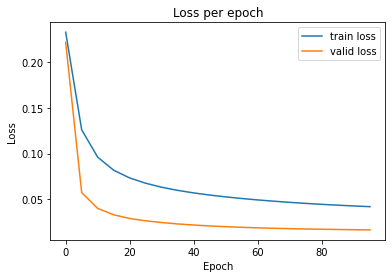

In [11]:
plt.plot(data['epoch'], data['loss'], label='train loss')
plt.plot(data['epoch'], data['valid loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()

Text(0.5, 1.0, 'AUC per epoch')

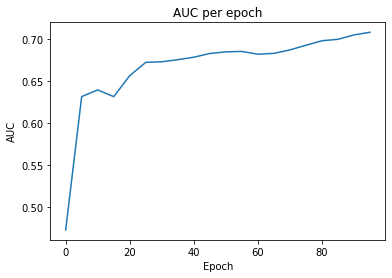

In [12]:
plt.plot(data['epoch'], data['auc'], label='auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per epoch')

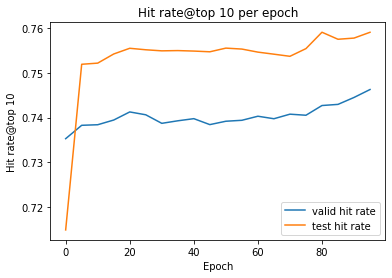

In [26]:
plt.plot(data['epoch'], data['valid hit rate'], label='valid hit rate')
plt.plot(data['epoch'], data['test hit rate'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch')
plt.legend()

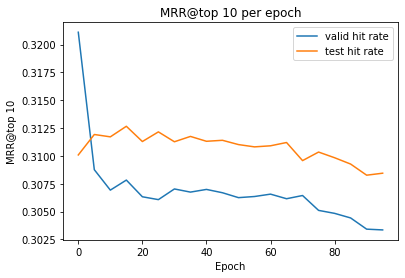

In [14]:
plt.plot(data['epoch'], data['valid MRR'], label='valid hit rate')
plt.plot(data['epoch'], data['test MRR'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 10')
plt.title('MRR@top 10 per epoch')
plt.legend()

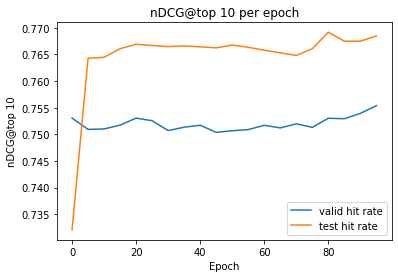

In [15]:
plt.plot(data['epoch'], data['valid nDCG'], label='valid hit rate')
plt.plot(data['epoch'], data['test nDCG'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 10')
plt.title('nDCG@top 10 per epoch')
plt.legend()

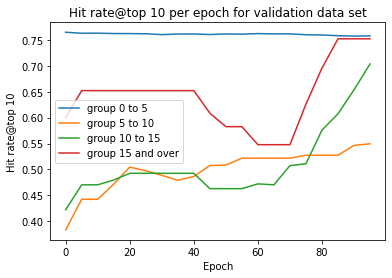

In [16]:
plt.plot(data['epoch'], data['hit rate valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch for validation data set')
plt.legend()

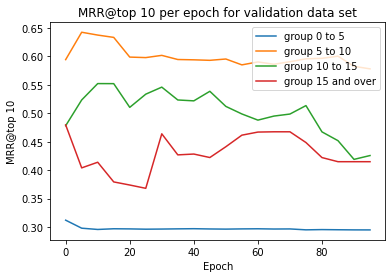

In [17]:
plt.plot(data['epoch'], data['MRR valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 10')
plt.title('MRR@top 10 per epoch for validation data set')
plt.legend()

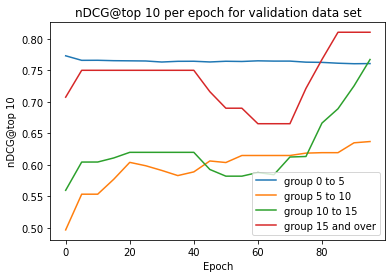

In [18]:
plt.plot(data['epoch'], data['nDCG valid group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['nDCG valid group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['nDCG valid group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['nDCG valid group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 10')
plt.title('nDCG@top 10 per epoch for validation data set')
plt.legend()

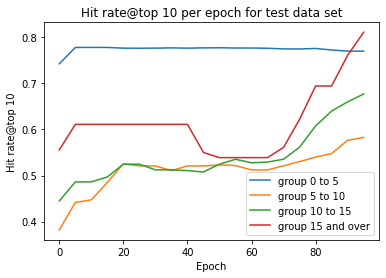

In [19]:
plt.plot(data['epoch'], data['hit rate test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['hit rate test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['hit rate test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['hit rate test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate@top 10')
plt.title('Hit rate@top 10 per epoch for test data set')
plt.legend()

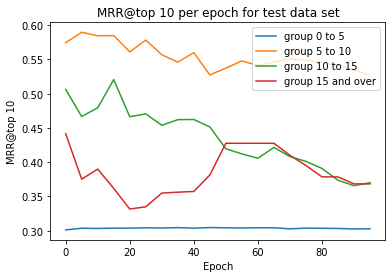

In [20]:
plt.plot(data['epoch'], data['MRR test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['MRR test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['MRR test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['MRR test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('MRR@top 10')
plt.title('MRR@top 10 per epoch for test data set')
plt.legend()

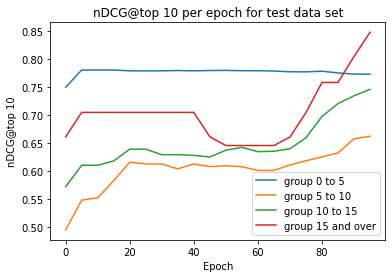

In [21]:
plt.plot(data['epoch'], data['nDCG test group 0-5'], label='group 0 to 5')
plt.plot(data['epoch'], data['nDCG test group 5-10'], label='group 5 to 10')
plt.plot(data['epoch'], data['nDCG test group 10-15'], label='group 10 to 15')
plt.plot(data['epoch'], data['nDCG test group 15-over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('nDCG@top 10')
plt.title('nDCG@top 10 per epoch for test data set')
plt.legend()

Text(0.5, 1.0, 'Hit rate')

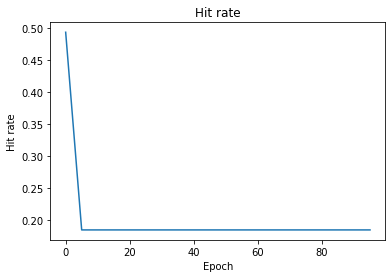

In [22]:
plt.plot(data['epoch'], data['hit rate test group 1'], label='Hit Rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate')

Text(0.5, 1.0, 'MRR')

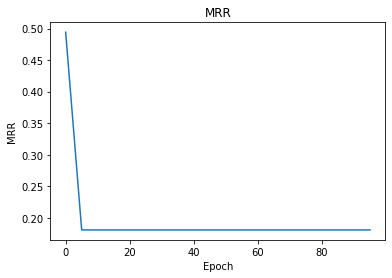

In [23]:
plt.plot(data['epoch'], data['MRR test group 1'], label='MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.title('MRR')

Text(0.5, 1.0, 'NDCG')

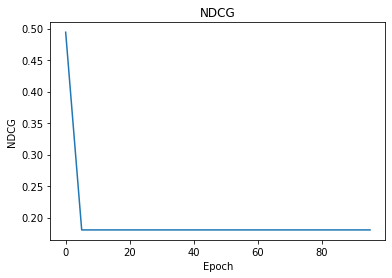

In [24]:
plt.plot(data['epoch'], data['nDCG test group 1'], label='NDCG')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.title('NDCG')

In [25]:
data['hit rate test group 1']

0     0.494118
1     0.184314
2     0.184314
3     0.184314
4     0.184314
5     0.184314
6     0.184314
7     0.184314
8     0.184314
9     0.184314
10    0.184314
11    0.184314
12    0.184314
13    0.184314
14    0.184314
15    0.184314
16    0.184314
17    0.184314
18    0.184314
19    0.184314
Name: hit rate test group 1, dtype: float64